# Approach 1a: Basic frame differencing
For this most basic approach, we compare each motion image $M$ to the closest lapse image $L$ and take the
1. mean absolute pixel-wise difference $ \frac{1}{xy} \sum_{x,y} | M_{x,y} - L_{x,y} | $
2. mean squared pixel-wise difference $ \frac{1}{xy} \sum_{x,y} (M_{x,y} - L_{x,y})^2 $
M and L are both grayscale.

**Reasoning:** We assume that anomalous images highly differ from the closest lapse image in a significant amount of pixels while normal images only have low pixel differences.

### Suspected problems
- **Noise** (we scale the images down for performance reasons which also reduces noise a bit)
- **Small object movements** that are not of interest (such as leaves, dust particles, etc.)
- Very sensitive to **camera movement** (which seems to happen a lot in the dataset)
- Since we eliminate the **color information**, a deer might look very much like a forest.

## Setup

In [10]:
%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from tqdm import tqdm
import warnings

from py.PlotUtils import plot_roc_curve, get_percentiles
from py.Dataset import Dataset
from py.Session import MotionImage
from py.ImageUtils import display_images, is_daytime
from py.Labels import LABELS
from py.ImageClassifier import AbstractImageClassifier

DIR = './ResizedSessions_NoBackup' # dataset directory

ds = Dataset(DIR)
session = ds.create_session("marten_01")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found 3 sessions
Session 'Marten_01' at folder: ./ResizedSessions_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Marten_01
Loaded scans.


## Experiment 1: Basic classifier
The proposed classifier computes the following features
- mean of absolute pixel-wise difference _absmean_
- variance of absolute pixel-wise difference _absvar_
- mean of squared pixel-wise difference _sqmean_
- var of squared pixel-wise difference _sqvar_

In [2]:
def normalize(comp_arr, motion_arr):
    # normalize comp_arr and transform motion_arr identically
    mean, std = np.mean(comp_arr), np.std(comp_arr)
    motion_arr = (motion_arr - mean) / std
    comp_arr = (comp_arr - mean) / std
    return comp_arr, motion_arr

def normalize_img(img):
    return (img - np.mean(img)) / np.std(img)

class FrameDiffClassifier(AbstractImageClassifier):
    def evaluate(self, motion_img: MotionImage, display=False):
        before_img, after_img, rel = motion_img.get_closest_lapse_images()
        comp_img = before_img if rel <= 0.5 else after_img
        motion_arr = motion_img.read(gray=False)
        comp_arr = comp_img.read(gray=False)
        motion_daytime = is_daytime(motion_arr)

        # don't compare daytime with nighttime images
        if motion_daytime != is_daytime(comp_arr):
            # choose the other closest lapse image
            comp_img = after_img if rel <= 0.5 else before_img
            comp_arr = comp_img.read(gray=False)
            assert motion_daytime == is_daytime(comp_arr)
            # if this assertion fails, a motion image was captured at daytime between two nighttime lapse images or the other way around

        # convert to gray
        motion_arr = rgb2gray(motion_arr)
        comp_arr = rgb2gray(comp_arr)

        # comp_arr, motion_arr = normalize(comp_arr, motion_arr)
        comp_arr, motion_arr = normalize_img(comp_arr), normalize_img(motion_arr)

        absdiff = abs(motion_arr - comp_arr)
        sqdiff = (motion_arr - comp_arr) ** 2
        absmean = np.average(absdiff)
        absstd = np.std(absdiff)
        sqmean = np.average(sqdiff)
        sqstd = np.std(sqdiff)

        if display:
            display_images([motion_arr, comp_arr, absdiff, sqdiff], ["Motion image", "Closest lapse image", f"abs mean = {absmean}, std = {absstd}", f"sq mean = {sqmean}, std = {sqstd}"], cmap="gray")

        return absmean, absstd, sqmean, sqstd

/home/kleinsteuber/vscode/py/Session.py:278: UserWarning: There are multiple lapse images for date 2021-04-26 11:00:00! Choosing the first one.
  warn(f"There are multiple lapse images for date {previous_date}! Choosing the first one.")
/home/kleinsteuber/vscode/py/Session.py:280: UserWarning: There are multiple lapse images for date 2021-04-26 12:00:00! Choosing the first one.
  warn(f"There are multiple lapse images for date {next_date}! Choosing the first one.")


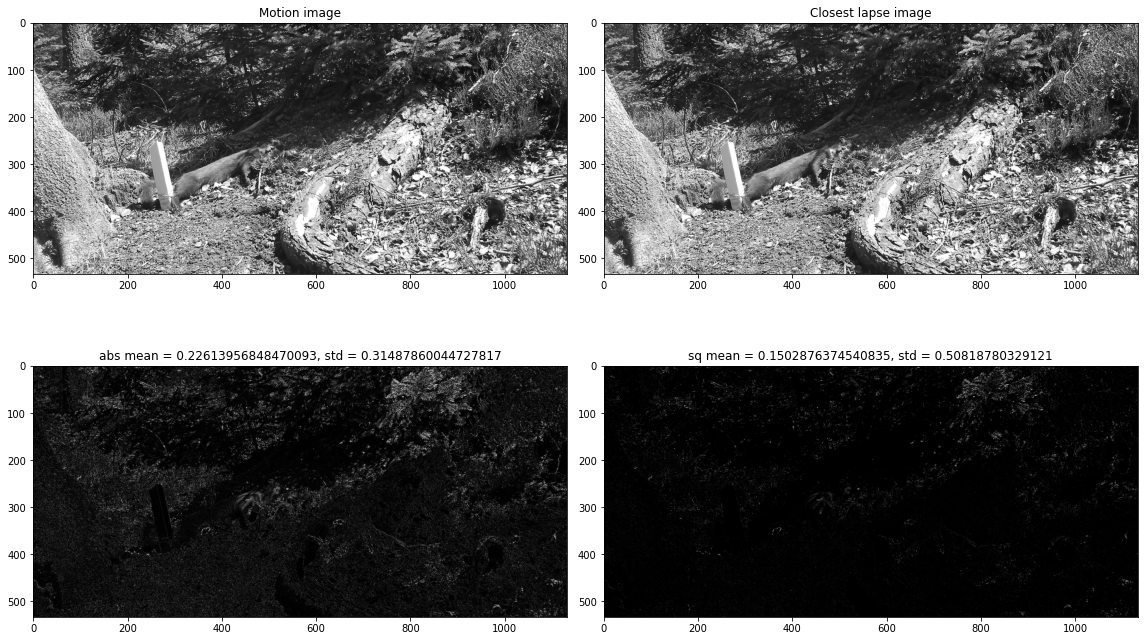

(0.22613956848470093,
 0.31487860044727817,
 0.1502876374540835,
 0.50818780329121)

In [3]:
img = session.get_random_motion_image(day_only=True)
classifier = FrameDiffClassifier()
classifier.evaluate(img, display=True)

The anomalous object is usually clearly visible in the difference image but there are still a lot of unwanted artefacts around it (possibly because of small object movement and noise).

In [4]:
def generate_test_scores(classifier):
    normal_scores = []
    anomalous_scores = []

    for img in tqdm(list(session.generate_motion_images())):
        img_nr = int(img.filename[-9:-4])
        if img_nr > LABELS[session.name]["max"] or img_nr in LABELS[session.name]["not_annotated"]:
            continue
        score = classifier.evaluate(img)
        if img_nr in LABELS[session.name]["normal"]:
            normal_scores.append(score)
        else:
            anomalous_scores.append(score)
    return normal_scores, anomalous_scores


classifier = FrameDiffClassifier()
normal_scores, anomalous_scores = generate_test_scores(classifier)

  0%|          | 0/3105 [00:00<?, ?it/s]/home/kleinsteuber/vscode/py/Session.py:278: UserWarning: There are multiple lapse images for date 2021-04-24 14:00:00! Choosing the first one.
  warn(f"There are multiple lapse images for date {previous_date}! Choosing the first one.")
/home/kleinsteuber/vscode/py/Session.py:280: UserWarning: There are multiple lapse images for date 2021-04-24 15:00:00! Choosing the first one.
  warn(f"There are multiple lapse images for date {next_date}! Choosing the first one.")
  0%|          | 1/3105 [00:00<12:19,  4.20it/s]/home/kleinsteuber/vscode/py/Session.py:278: UserWarning: There are multiple lapse images for date 2021-06-21 12:00:00! Choosing the first one.
  warn(f"There are multiple lapse images for date {previous_date}! Choosing the first one.")
/home/kleinsteuber/vscode/py/Session.py:280: UserWarning: There are multiple lapse images for date 2021-06-21 13:00:00! Choosing the first one.
  warn(f"There are multiple lapse images for date {next_date}

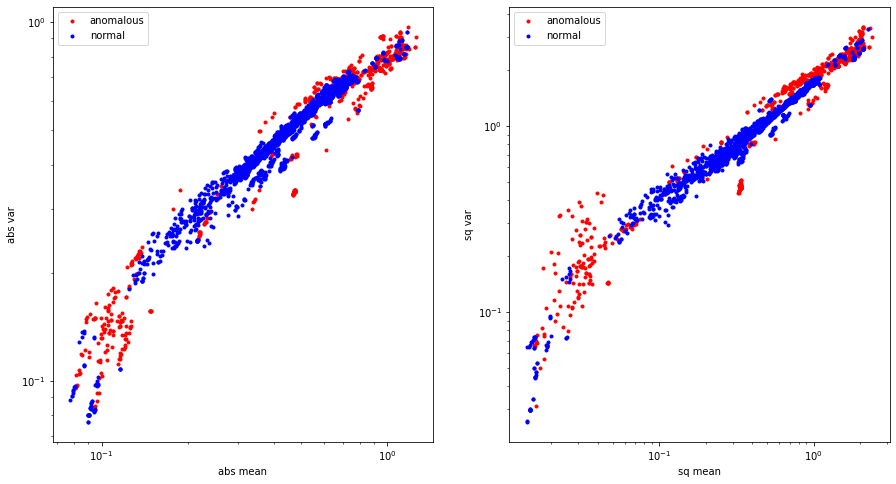

In [5]:
def plot(i1, i2, normal_scores, anomalous_scores, scale="log"):
    titles = ["abs mean", "abs var", "sq mean", "sq var"]
    plt.scatter([ar[i1] for ar in anomalous_scores], [ar[i2] for ar in anomalous_scores], color="red", label="anomalous", marker=".")
    plt.scatter([ar[i1] for ar in normal_scores], [ar[i2] for ar in normal_scores], color="blue", label="normal", marker=".")
    plt.xlabel(titles[i1])
    plt.ylabel(titles[i2])
    plt.xscale(scale)
    plt.yscale(scale)
    plt.legend()
    
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plot(0, 1, normal_scores, anomalous_scores)
plt.subplot(1, 2, 2)
plot(2, 3, normal_scores, anomalous_scores)
plt.show()

In [6]:
y_anom = np.array(anomalous_scores)
assert y_anom.shape[1] == 4

y_norm = np.array(normal_scores)
assert y_norm.shape[1] == 4

X = np.concatenate([y_norm, y_anom])
print(X.shape)
y = np.concatenate([-np.ones((y_norm.shape[0])), np.ones((y_anom.shape[0]))])
print(y.shape)

(3105, 4)
(3105,)


absmean auc=0.6355777888310892
0.9 percentile : TPR = 0.9071, FPR = 0.9768 <-> TNR = 0.0232 @ thresh 0.10961586920510108
0.95 percentile : TPR = 0.9604, FPR = 0.9768 <-> TNR = 0.0232 @ thresh 0.09733281438072432
0.98 percentile : TPR = 0.9850, FPR = 0.9928 <-> TNR = 0.0072 @ thresh 0.08730197912012297
0.99 percentile : TPR = 0.9918, FPR = 0.9958 <-> TNR = 0.0042 @ thresh 0.0835324211615366
absvar auc=0.6136761126424554
0.9 percentile : TPR = 0.9003, FPR = 0.9756 <-> TNR = 0.0244 @ thresh 0.14628162651577775
0.95 percentile : TPR = 0.9768, FPR = 0.9785 <-> TNR = 0.0215 @ thresh 0.11149615637214694
0.98 percentile : TPR = 0.9850, FPR = 0.9810 <-> TNR = 0.0190 @ thresh 0.10304412579457048
0.99 percentile : TPR = 0.9904, FPR = 0.9853 <-> TNR = 0.0147 @ thresh 0.096197918856062
sqmean auc=0.6279026456561636
0.9 percentile : TPR = 0.9208, FPR = 0.9756 <-> TNR = 0.0244 @ thresh 0.030851647496162603
0.95 percentile : TPR = 0.9590, FPR = 0.9756 <-> TNR = 0.0244 @ thresh 0.0264403832629429
0.98 

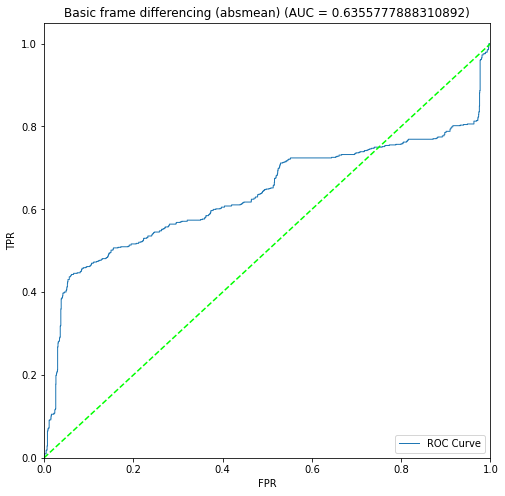

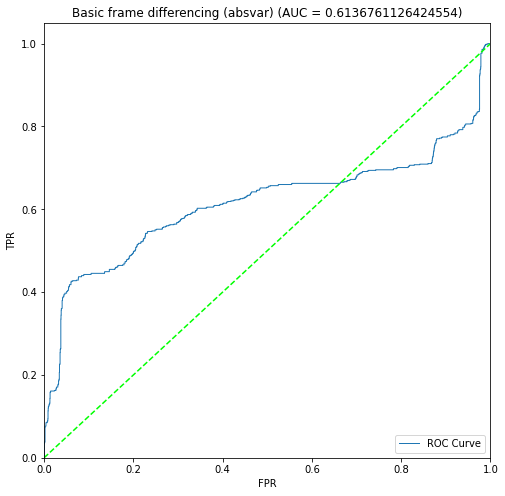

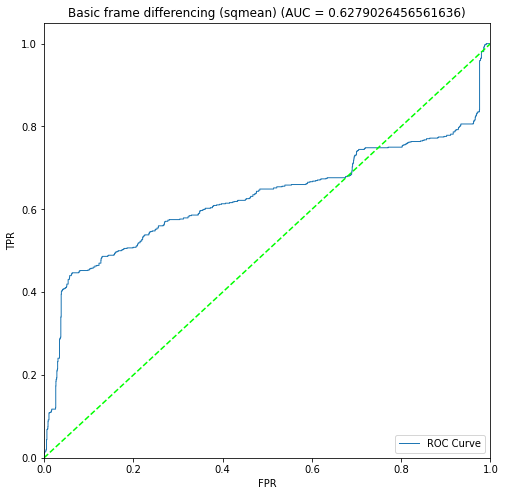

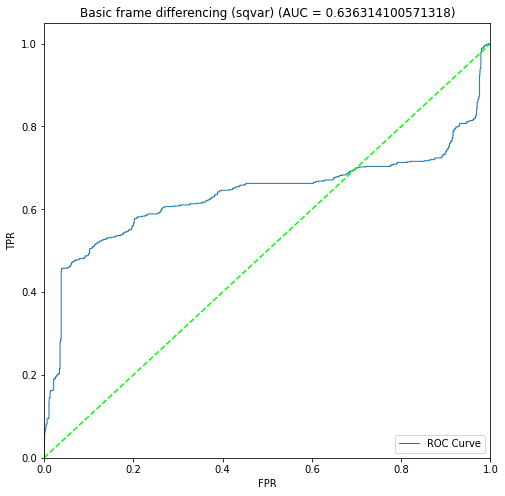

In [7]:
vals = ["absmean", "absvar", "sqmean", "sqvar"]
for i in range(4):
    fpr, tpr, thresholds, auc_score = plot_roc_curve(y, X[:,i], f"Basic frame differencing ({vals[i]})", savefile=f"plots/approach1a/roc_curves/{session.name}_{vals[i]}", show=False)
    print(f"{vals[i]} auc={auc_score}")
    get_percentiles(fpr, tpr, thresholds)

## Experiment 2: Add a Gaussian filter

In [8]:
from py.ImageClassifier import AbstractImageClassifier
from scipy import ndimage

class GaussianFrameDiffClassifier(AbstractImageClassifier):
    def __init__(self, sigma: int):
        self.sigma = sigma
    
    def evaluate(self, motion_img: MotionImage, display=False):
        before_img, after_img, rel = motion_img.get_closest_lapse_images()
        comp_img = before_img if rel <= 0.5 else after_img
        motion_arr = motion_img.read(gray=False)
        comp_arr = comp_img.read(gray=False)
        motion_daytime = is_daytime(motion_arr)

        # don't compare daytime with nighttime images
        if motion_daytime != is_daytime(comp_arr):
            # choose the other closest lapse image
            comp_img = after_img if rel <= 0.5 else before_img
            comp_arr = comp_img.read(gray=False)
            assert motion_daytime == is_daytime(comp_arr)
            # if this assertion fails, a motion image was captured at daytime between two nighttime lapse images or the other way around

        # convert to gray
        motion_arr = rgb2gray(motion_arr)
        comp_arr = rgb2gray(comp_arr)

        comp_arr, motion_arr = normalize_img(comp_arr), normalize_img(motion_arr)

        motion_arrg = ndimage.gaussian_filter(motion_arr, sigma=self.sigma)
        comp_arrg = ndimage.gaussian_filter(comp_arr, sigma=self.sigma)

        absdiff = abs(motion_arrg - comp_arrg)
        sqdiff = (motion_arrg - comp_arrg) ** 2
        absmean = np.average(absdiff)
        absvar = np.var(absdiff)
        sqmean = np.average(sqdiff)
        sqvar = np.var(sqdiff)

        if display:
            display_images([motion_arr, comp_arr, absdiff, sqdiff], ["Motion image", "Closest lapse image", f"abs mean = {absmean}, var = {absvar}", f"sq mean = {sqmean}, var = {sqvar}"], cmap="gray")

        return absmean, absvar, sqmean, sqvar

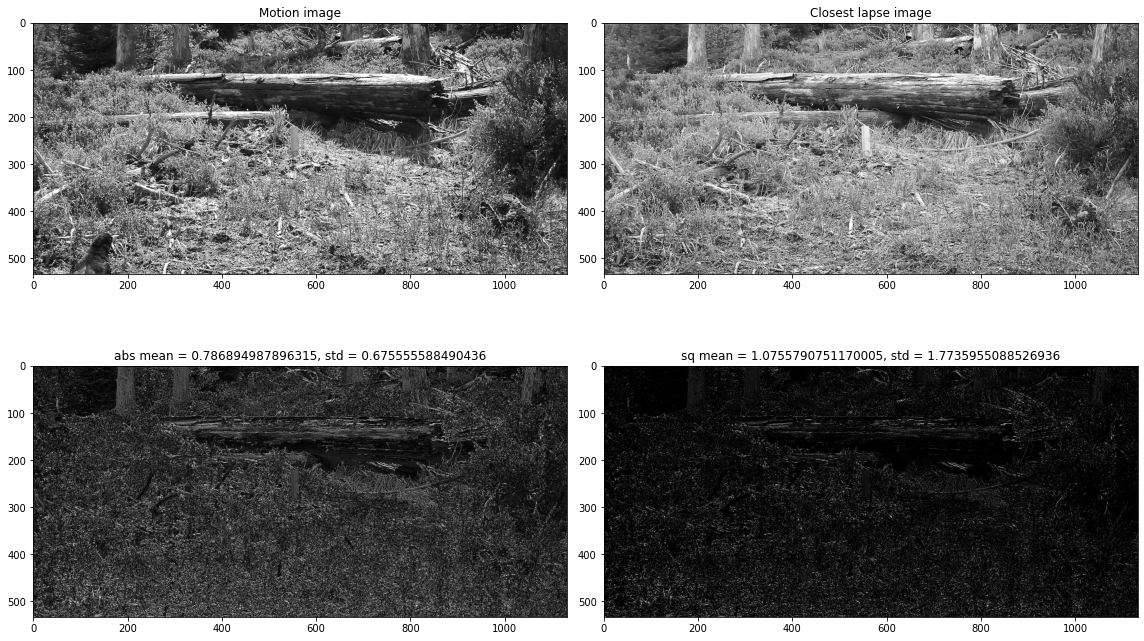

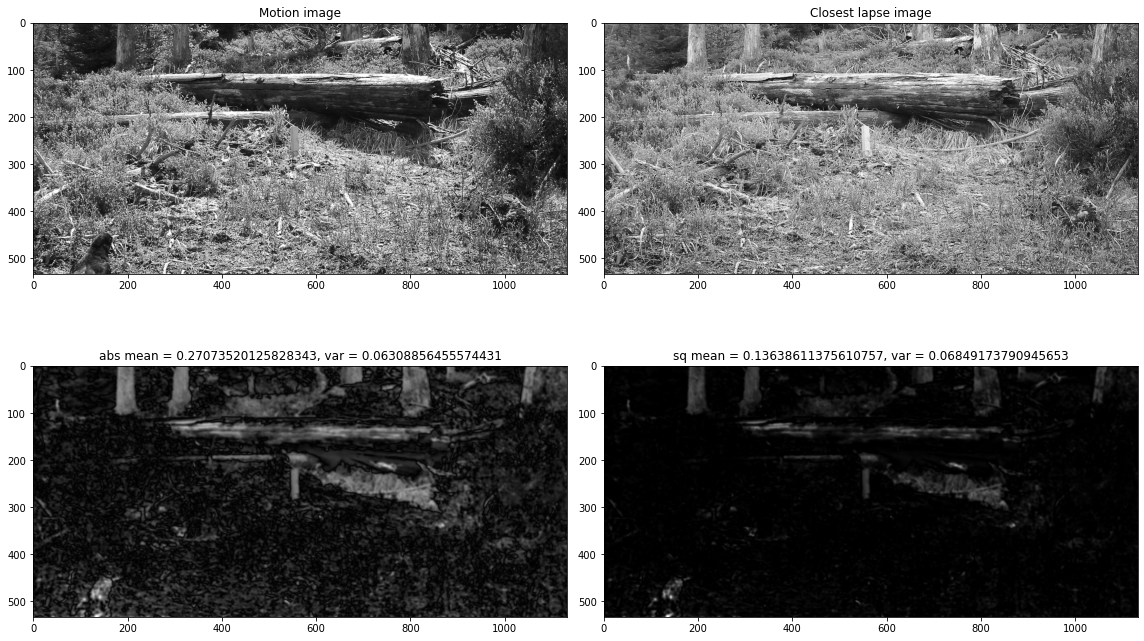

(0.27073520125828343,
 0.06308856455574431,
 0.13638611375610757,
 0.06849173790945653)

In [14]:
img = session.get_random_motion_image(day_only=True)
classifier = FrameDiffClassifier()
classifier.evaluate(img, display=True)
classifier2 = GaussianFrameDiffClassifier(sigma=2)
classifier2.evaluate(img, display=True)

In [12]:
classifier = GaussianFrameDiffClassifier(sigma=2)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    normal_scores_g, anomalous_scores_g = generate_test_scores(classifier)

100%|██████████| 3105/3105 [05:40<00:00,  9.11it/s]


In [13]:
classifier = GaussianFrameDiffClassifier(sigma=4)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    normal_scores_g2, anomalous_scores_g2 = generate_test_scores(classifier)

100%|██████████| 3105/3105 [06:32<00:00,  7.90it/s]


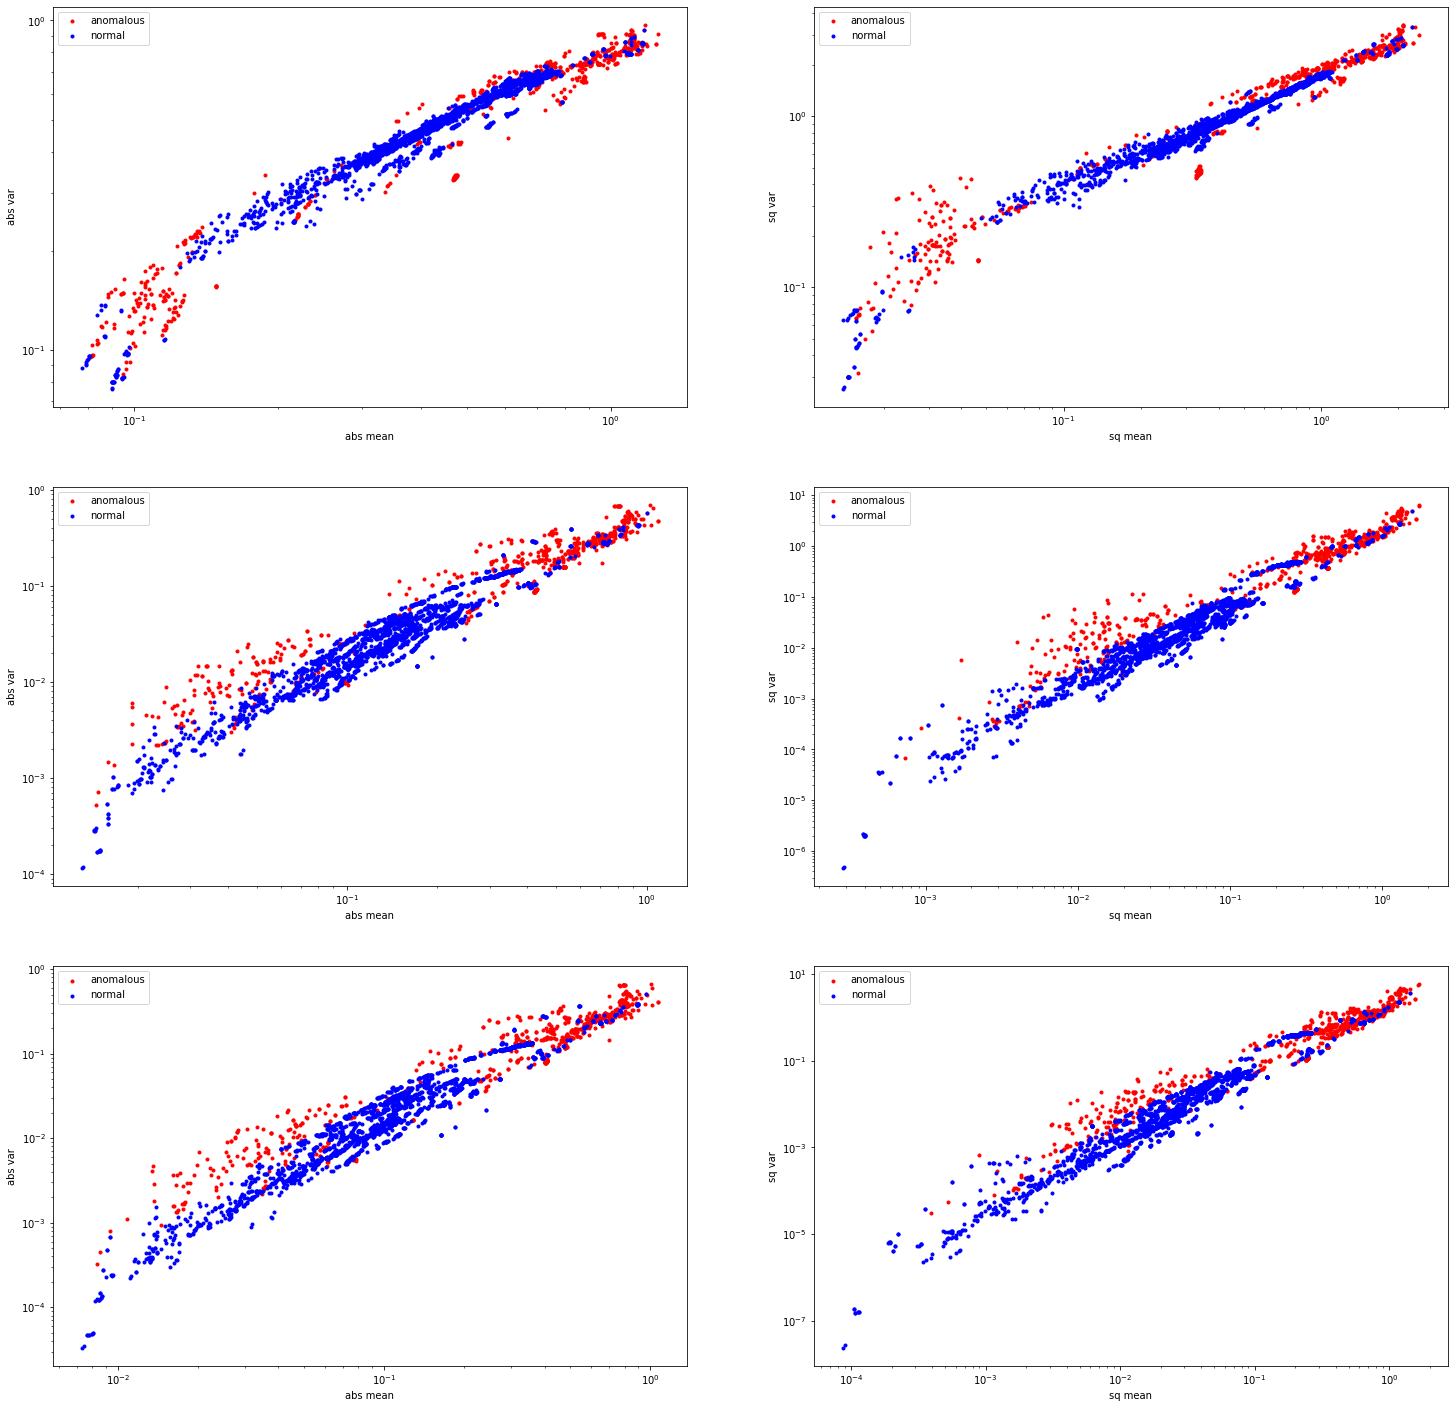

In [14]:
scale = "log"
plt.figure(figsize=(25, 25))
plt.subplot(3, 2, 1)
plot(0, 1, normal_scores, anomalous_scores, scale=scale)
plt.subplot(3, 2, 2)
plot(2, 3, normal_scores, anomalous_scores, scale=scale)
plt.subplot(3, 2, 3)
plot(0, 1, normal_scores_g, anomalous_scores_g, scale=scale)
plt.subplot(3, 2, 4)
plot(2, 3, normal_scores_g, anomalous_scores_g, scale=scale)
plt.subplot(3, 2, 5)
plot(0, 1, normal_scores_g2, anomalous_scores_g2, scale=scale)
plt.subplot(3, 2, 6)
plot(2, 3, normal_scores_g2, anomalous_scores_g2, scale=scale)
plt.show()

(3105, 4)
(3105,)
absmean sigma=2 auc=0.7343149479918666
0.9 percentile : TPR = 0.9044, FPR = 0.9305 <-> TNR = 0.0695 @ thresh 0.04189018513455361
0.95 percentile : TPR = 0.9522, FPR = 0.9536 <-> TNR = 0.0464 @ thresh 0.030741939714378524
0.98 percentile : TPR = 0.9809, FPR = 0.9667 <-> TNR = 0.0333 @ thresh 0.024490966181716485
0.99 percentile : TPR = 0.9945, FPR = 0.9861 <-> TNR = 0.0139 @ thresh 0.01912522696915488
absvar sigma=2 auc=0.7596045792948447
0.9 percentile : TPR = 0.9003, FPR = 0.8453 <-> TNR = 0.1547 @ thresh 0.00890683961181721
0.95 percentile : TPR = 0.9508, FPR = 0.9107 <-> TNR = 0.0893 @ thresh 0.0053697512333138065
0.98 percentile : TPR = 0.9809, FPR = 0.9376 <-> TNR = 0.0624 @ thresh 0.003388116441157873
0.99 percentile : TPR = 0.9945, FPR = 0.9587 <-> TNR = 0.0413 @ thresh 0.002191292826771949
sqmean sigma=2 auc=0.7527664941889518
0.9 percentile : TPR = 0.9003, FPR = 0.8710 <-> TNR = 0.1290 @ thresh 0.011505579188949766
0.95 percentile : TPR = 0.9508, FPR = 0.9204

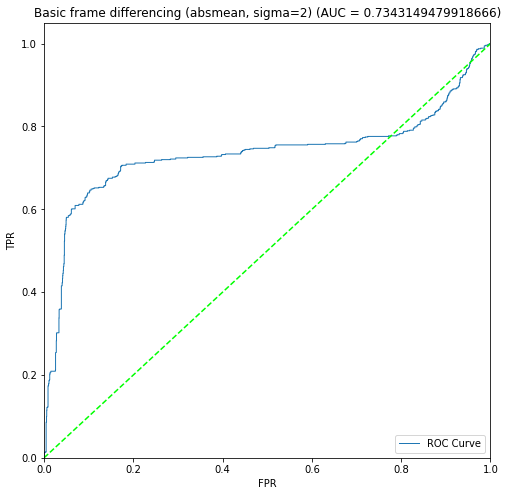

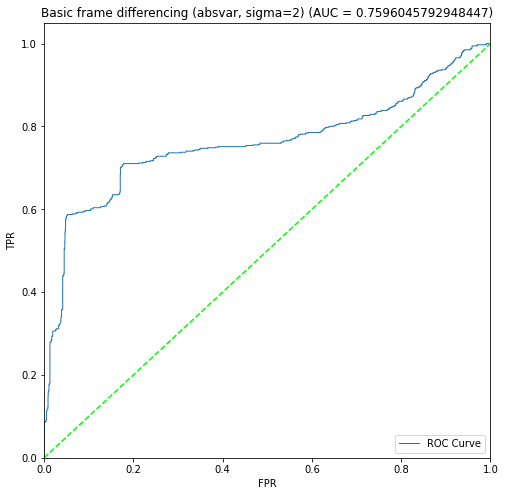

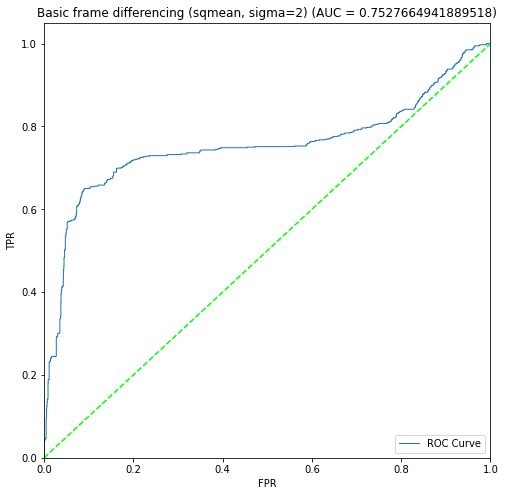

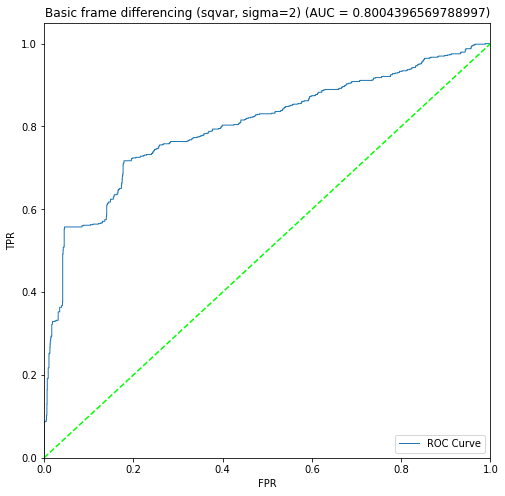

In [16]:
# Display ROC Curve
sigma = 2
assert sigma in [2, 4]
y_anom = np.array(anomalous_scores_g2 if sigma == 4 else anomalous_scores_g)
assert y_anom.shape[1] == 4

y_norm = np.array(normal_scores_g2 if sigma == 4 else normal_scores_g)
assert y_norm.shape[1] == 4

X = np.concatenate([y_norm, y_anom])
print(X.shape)
y = np.concatenate([-np.ones((y_norm.shape[0])), np.ones((y_anom.shape[0]))])
print(y.shape)

vals = ["absmean", "absvar", "sqmean", "sqvar"]
for i in range(4):
    fpr, tpr, thresholds, auc_score = plot_roc_curve(y, X[:,i], f"Basic frame differencing ({vals[i]}, sigma=2)", savefile=f"plots/approach1a/roc_curves/{session.name}_{vals[i]}_sigma{sigma}", show=False)
    print(f"{vals[i]} sigma={sigma} auc={auc_score}")
    get_percentiles(fpr, tpr, thresholds)